# **AIRS dataset with U-Net model**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json, load_model
import torch
from tensorflow.keras.optimizers import Adam
# from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline


In [2]:
train_image_paths_list = []
train_gt_paths_list_samp = []
train_image_path = '../input/roof-google/train/image'
train_label_path = '../input/roof-google/train/mask'

for img_path in glob.glob(os.path.join(train_image_path, '*.jpg')):
    train_image_paths_list.append(str(img_path))   
print("Total aerial satellite images : ",len(train_image_paths_list))

for img_path in glob.glob(os.path.join(train_label_path, '*.png')):
    train_gt_paths_list_samp.append(str(img_path))
print("Total segmented mask images samp: ",len(train_gt_paths_list_samp))

train_gt_paths_list = []
for i in range(len(train_gt_paths_list_samp)):
    filename = train_gt_paths_list_samp[i].split('_')
    #if len(filename) == 0
    train_gt_paths_list.append(train_gt_paths_list_samp[i])
print("Total segmented mask images : ",len(train_gt_paths_list))

train_image_paths_list.sort()
train_gt_paths_list.sort()


Total aerial satellite images :  178
Total segmented mask images samp:  178
Total segmented mask images :  178


In [3]:
#print(train_image_paths_list, train_gt_paths_list)

In [4]:
train_X = []
for img in train_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X.append(resized_img)


In [5]:
train_Y = []
for img in train_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_Y.append(resized_img)
    
print(len(train_X), len(train_Y))

178 178


In [6]:
val_image_paths_list = []
val_gt_paths_list_samp = []
val_image_path = '../input/roof-google/val/image'
val_label_path = '../input/roof-google/val/mask'

for img_path in glob.glob(os.path.join(val_image_path, '*.jpg')):
    val_image_paths_list.append(str(img_path))        
print("Total aerial images in vaidation set : ",len(val_image_paths_list))

for img_path in glob.glob(os.path.join(val_label_path, '*.png')):
    val_gt_paths_list_samp.append(str(img_path))        
print("Total segmented mask images in validation set : ",len(val_gt_paths_list_samp))

val_gt_paths_list = []
for i in range(len(val_gt_paths_list_samp)):
    filename = val_gt_paths_list_samp[i].split('_')
    #if len(filename) == 4:
    val_gt_paths_list.append(val_gt_paths_list_samp[i])
print("Total segmented mask images : ",len(val_gt_paths_list))

val_image_paths_list.sort()
val_gt_paths_list.sort()

Total aerial images in vaidation set :  11
Total segmented mask images in validation set :  11
Total segmented mask images :  11


In [7]:
val_X = []
val_Y = []
for img in val_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_X.append(resized_img)
    
for img in val_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_Y.append(resized_img)
    
print(len(val_X), len(val_Y))


11 11


In [8]:
test_image_paths_list = []
test_gt_paths_list_samp = []
test_image_path = '../input/roof-google/test/image'
test_label_path = '../input/roof-google/test/mask'

for img_path in glob.glob(os.path.join(test_image_path, '*.jpg')):
    test_image_paths_list.append(str(img_path))        
print("Total aerial images in testing set : ",len(test_image_paths_list))

for img_path in glob.glob(os.path.join(test_label_path, '*.png')):
    test_gt_paths_list_samp.append(str(img_path))        
print("Total segmented mask images in testing set : ",len(test_gt_paths_list_samp))

test_gt_paths_list = []
for i in range(len(test_gt_paths_list_samp)):
    filename = test_gt_paths_list_samp[i].split('_')
    #if len(filename) == 4:
    test_gt_paths_list.append(test_gt_paths_list_samp[i])
print("Total segmented mask images : ",len(test_gt_paths_list))

test_image_paths_list.sort()
test_gt_paths_list.sort()


Total aerial images in testing set :  18
Total segmented mask images in testing set :  18
Total segmented mask images :  18


In [9]:
test_X = []
test_Y = []
for img in test_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test_X.append(resized_img)
    
for img in test_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test_Y.append(resized_img)
    
print(len(test_X), len(test_Y))


18 18


In [10]:
scaler = MinMaxScaler()
train_X = np.array(train_X)
train_Y = np.array(train_Y)

train_Y = train_Y.reshape((train_Y.shape[0],train_Y.shape[1],train_Y.shape[2],1))

scaler = MinMaxScaler()
train_X_scaler = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
train_Y_scaler = scaler.fit_transform(train_Y.reshape(-1, train_Y.shape[-1])).reshape(train_Y.shape)
print(train_X_scaler.shape, train_Y_scaler.shape)


(178, 256, 256, 3) (178, 256, 256, 1)


In [11]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)

val_Y = val_Y.reshape((val_Y.shape[0],val_Y.shape[1],val_Y.shape[2],1))

val_X = scaler.fit_transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
val_Y = scaler.fit_transform(val_Y.reshape(-1, val_Y.shape[-1])).reshape(val_Y.shape)


print(val_X.shape)
print(val_Y.shape)

(11, 256, 256, 3)
(11, 256, 256, 1)


In [12]:
test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_Y = test_Y.reshape((test_Y.shape[0],test_Y.shape[1],test_Y.shape[2],1))

test_X = scaler.fit_transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
test_Y = scaler.fit_transform(test_Y.reshape(-1, test_Y.shape[-1])).reshape(test_Y.shape)


print(test_X.shape)
print(test_Y.shape)


(18, 256, 256, 3)
(18, 256, 256, 1)


In [13]:
g_x = []
g_y = []
g_image_path = ['../input/roof-google/test/image/ind187.jpg']
g_label_path = ['../input/roof-google/test/mask/ind187.png']


for img in g_image_path:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    g_x.append(resized_img)
    
for img in g_label_path:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    g_y.append(resized_img)
    

print(len(g_x),len(g_y))


1 1


In [14]:
g_x = np.array(g_x)
g_y = np.array(g_y)

g_y = g_y.reshape((g_y.shape[0],g_y.shape[1],g_y.shape[2],1))

g_x = scaler.fit_transform(g_x.reshape(-1, g_x.shape[-1])).reshape(g_x.shape)
g_y = scaler.fit_transform(g_y.reshape(-1, g_y.shape[-1])).reshape(g_y.shape)


print(g_x.shape)
print(g_y.shape)

(1, 256, 256, 3)
(1, 256, 256, 1)


In [15]:
def IOU(y_true, y_pred):
    smooth = 1.0
  # y_true = y_true.astype('float32')
  # y_pred = y_pred.astype('float32')
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    # jacc = intersection / (union + K.epsilon())
    jacc = (intersection + smooth) / (union + smooth)
    return jacc

def dice_coef(y_true, y_pred):
    smooth = 1.0
    # y_true = y_true.astype('float32')
    # y_pred = y_pred.astype('float32')
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc(y_true, y_pred):
    smooth = 1.0
    # y_true = y_true.astype('float32')
    # y_pred = y_pred.astype('float32')
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    tp = K.sum(y_true_f * y_pred_f)
    tn = K.sum((1-y_true_f) * (1-y_pred_f))
    fp = K.sum((1-y_true_f)*y_pred_f)
    fn = K.sum(y_true_f * (1-y_pred_f))
    up = tp*tn - fp*fn
    down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))
    mcc = (up + smooth) / (down + smooth)
    return mcc


In [16]:
!pip install keras-unet
from keras_unet.models import satellite_unet


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [17]:
UNetModel = satellite_unet(input_shape=(256, 256, 3))
UNetModel.summary()

2022-06-05 10:28:00.038268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 10:28:00.040889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 10:28:00.042228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 10:28:00.045200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
UNetModel.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

In [20]:
history = UNetModel.fit(x = train_X_scaler, y = train_Y_scaler, validation_data = (val_X, val_Y), batch_size = 8, verbose = 1, epochs = 100)

Epoch 1/100
23/23 [==============================] - 8s 355ms/step - loss: 0.2077 - IOU: 0.5911 - mcc: 0.6921 - dice_coef: 0.7391 - accuracy: 0.9116 - val_loss: 0.6003 - val_IOU: 0.4598 - val_mcc: 0.5456 - val_dice_coef: 0.6296 - val_accuracy: 0.7847
Epoch 2/100
23/23 [==============================] - 7s 315ms/step - loss: 0.1989 - IOU: 0.6081 - mcc: 0.7065 - dice_coef: 0.7537 - accuracy: 0.9158 - val_loss: 0.3943 - val_IOU: 0.5375 - val_mcc: 0.6195 - val_dice_coef: 0.6984 - val_accuracy: 0.8538
Epoch 3/100
23/23 [==============================] - 7s 298ms/step - loss: 0.1965 - IOU: 0.6130 - mcc: 0.7121 - dice_coef: 0.7578 - accuracy: 0.9165 - val_loss: 0.3653 - val_IOU: 0.5011 - val_mcc: 0.5758 - val_dice_coef: 0.6674 - val_accuracy: 0.8463
Epoch 4/100
23/23 [==============================] - 7s 279ms/step - loss: 0.1957 - IOU: 0.6224 - mcc: 0.7193 - dice_coef: 0.7643 - accuracy: 0.9172 - val_loss: 0.3907 - val_IOU: 0.5322 - val_mcc: 0.6208 - val_dice_coef: 0.6945 - val_accuracy: 0.8

In [21]:
UNetModel.save('unet-256-model-100epochs', save_format = 'tf')
UNetModel.save_weights('unet-256-weights-100epochs', save_format = 'tf')


2022-06-05 10:44:54.300596: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


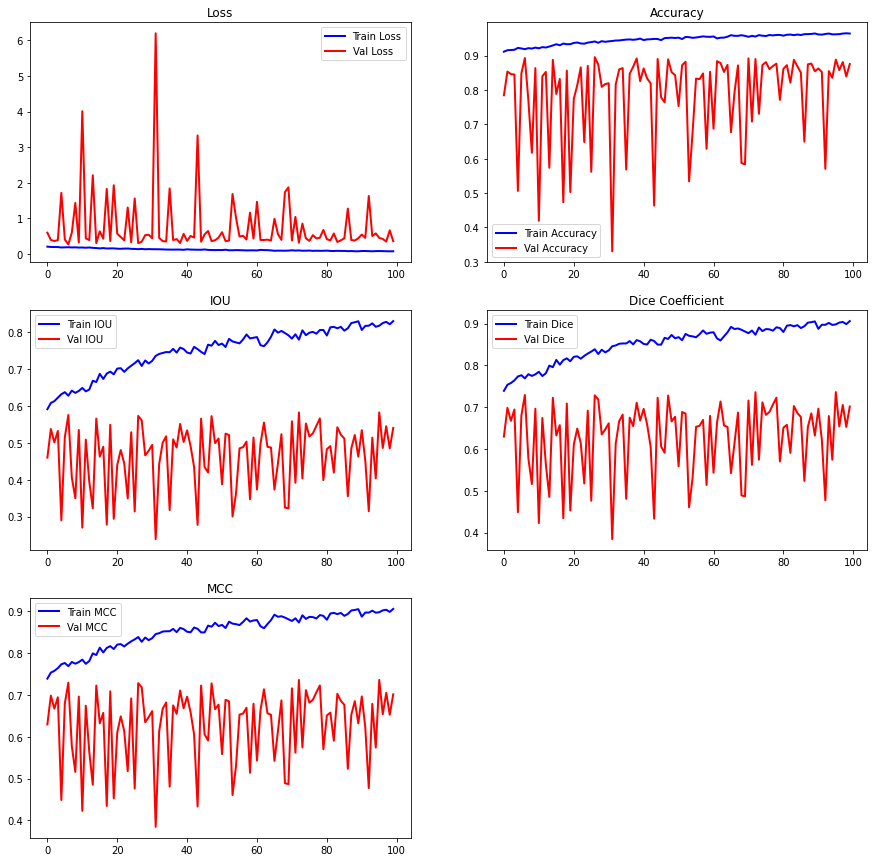

In [22]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
epoch_val_acc = history.history['val_accuracy']
epoch_jac = history.history['IOU']
epoch_val_jac = history.history['val_IOU']
epoch_dice = history.history['dice_coef']
epoch_val_dice = history.history['val_dice_coef']
epoch_mcc = history.history['mcc']
epoch_val_mcc = history.history['val_mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val IOU')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_dice, 'b-', linewidth=2, label='Train MCC')
plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

Image number: 0


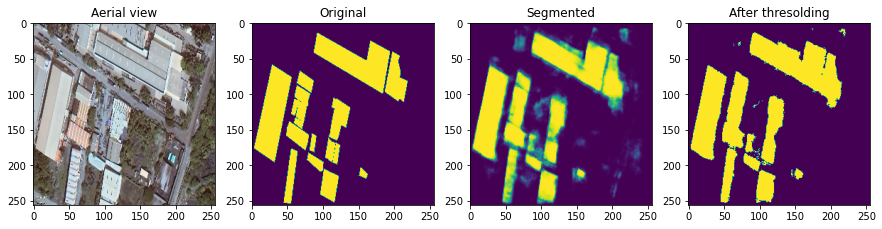

In [33]:
from matplotlib import pyplot 
rows = 1
columns = 4
count = 1
for image_number in range(0,1):

    fig = plt.figure(figsize=(15,15))
    print('Image number: {0}'.format(image_number))
    pred_y = UNetModel.predict(g_x[image_number:image_number+1])
    pred_y_thresold = (pred_y[0,:,:,0] > 0.5)

    fig.add_subplot(rows, columns, count+1)
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(g_x[image_number:image_number+1]))
    plt.title('Aerial view')

    fig.add_subplot(rows, columns, count+1)
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(g_y[image_number:image_number+1]))
    plt.title('Original')

    fig.add_subplot(rows, columns, count+2)
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred_y[0]))
    plt.title('Segmented')
    #count += 3

    fig.add_subplot(rows, columns, count+3)
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred_y_thresold))
    plt.title('After thresolding')
    count += 4
    pyplot.imsave('./thresold_pred.png',pred_y_thresold,cmap='gray')
    cv2.imwrite('./original_ind187.png',g_x[0])

   # print("\nIOU Score: {0} \nDice Coefficent: {1} \nMCC: {2}".format(IOU(val_Y[image_number:image_number+1], pred_y), dice_coef(val_Y[image_number:image_number+1], pred_y), mcc(val_Y[image_number:image_number+1], pred_y)))
    plt.show()

In [42]:
def draw_bb_color_filling(img, img_mask):

    # convert to grayscale
    gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

    # threshold
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)[1]

    # get contours
    result = img_mask.copy()
    seg_with_bounded_box = img_mask.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    print("No of identified buildings: {0}".format(len(contours)))
    bb = []

    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 1)
        cv2.rectangle(seg_with_bounded_box, (x, y), (x+w, y+h), (255, 255, 255), -1)
        bb.append([x,y,w,h])
        print(cv2.contourArea(cntr))

    print(bb)   
#     plt.imshow(contours)
#     plt.title('contours with bounding box')
#     plt.show()

    plt.imshow(seg_with_bounded_box)
    plt.title('Segmented mask with bounding box and color filling')
    plt.show()

    plt.imshow(result)
    plt.title('Segmented mask with bounding box')
    plt.show()

    return bb, seg_with_bounded_box, result

No of identified buildings: 27
4.5
1.0
894.5
106.5
0.0
1.0
0.0
0.5
1.5
0.0
207.5
0.0
5.5
0.0
0.0
0.0
1957.5
3084.5
3602.0
0.0
0.0
0.0
9.0
0.0
5702.0
27.5
0.0
[[145, 210, 3, 6], [145, 206, 3, 3], [95, 206, 28, 47], [149, 204, 13, 16], [99, 187, 1, 1], [96, 187, 4, 4], [93, 185, 1, 1], [98, 182, 3, 4], [93, 176, 8, 6], [92, 155, 1, 1], [80, 155, 16, 27], [135, 125, 1, 1], [91, 114, 7, 5], [99, 113, 1, 1], [99, 110, 2, 2], [104, 109, 1, 1], [78, 102, 58, 107], [46, 68, 40, 185], [4, 59, 51, 134], [191, 34, 1, 1], [64, 31, 1, 1], [64, 29, 1, 1], [70, 26, 4, 6], [127, 25, 1, 1], [86, 13, 131, 107], [212, 8, 10, 11], [174, 7, 2, 3]]


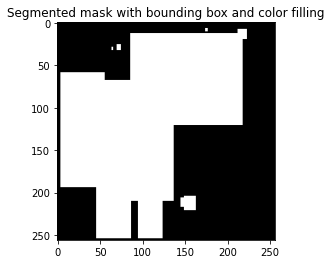

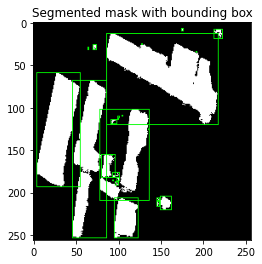

([[145, 210, 3, 6],
  [145, 206, 3, 3],
  [95, 206, 28, 47],
  [149, 204, 13, 16],
  [99, 187, 1, 1],
  [96, 187, 4, 4],
  [93, 185, 1, 1],
  [98, 182, 3, 4],
  [93, 176, 8, 6],
  [92, 155, 1, 1],
  [80, 155, 16, 27],
  [135, 125, 1, 1],
  [91, 114, 7, 5],
  [99, 113, 1, 1],
  [99, 110, 2, 2],
  [104, 109, 1, 1],
  [78, 102, 58, 107],
  [46, 68, 40, 185],
  [4, 59, 51, 134],
  [191, 34, 1, 1],
  [64, 31, 1, 1],
  [64, 29, 1, 1],
  [70, 26, 4, 6],
  [127, 25, 1, 1],
  [86, 13, 131, 107],
  [212, 8, 10, 11],
  [174, 7, 2, 3]],
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
   

In [43]:
img = cv2.imread('./original_ind187.png',cv2.IMREAD_COLOR)
img_mask = cv2.imread('./thresold_pred.png',cv2.IMREAD_COLOR)
draw_bb_color_filling(img,img_mask)